# Biblio - Book Recommendation System
### by Maxwel G. Mazel

## Problem Statement

MGM Books, a brick and mortar bookstore, is attempting to recover from layoffs due to the COVID19 pandemic. Following guidelines set by the city and state for reopening adjustments have to be made. In order to reduce contact customer contact with staff, I was assigned to create an applet that functions as a book recommendation system. In place of the staff’s years of knowledge on book sales, a machine learning model will update its recommendations every time a customer rates a book. Using the cosine similarity trained to the extremely large Amazon Books reviews data set, a model will be created. As the customer rates a book, it will dynamically update the underlying model with new similar books. The reviews by the customer will then be saved in the data set so it can learn trends the more it is used. This applet will also have the ability to be used as a search engine to find similar books as well as a promotional targeting tool.

## Executive Summary

The data that was used was downloaded from an Amazon review study done by Jianmo Ni, UCSD. Two different data sets were combined, one that had every customer book review between 2009 and 2018, and one with the book information that is associated with each book found in the review data set. This data included reviews and information on over 29million books and 54million individual reviews. In order to get the data set to only have reviews that would help the model that was being created, minimal review count and reviewer parameters were set.  
  
The minimum review count of a book was set to 500 hundred reviews. In my data exploration, I found that books that had less than that tended to have higher ratings due to biased circumstances such as fan clubs for a musician. The number of books a customer has reviewed was set to 10. This amount reflected the minimum number of books that a future application will require a user to submit in order to have a profile.  
  
Once the data set was created and reduced down to 3.4million reviews a pivot table was rendered with book title as the index, reviewer id as the columns, and review overall score as the values. This pivot table was then used as the vectors when creating a cosine similarity sparse matrix. I chose this metric because it returns a table that shows how similar the index items are given the input vectors. Given that this is an unsupervised model the quality is assessed by user interpretation and not an output metric.  
  
After the model was run, I was able to query the results by typing in the name of a book. Returned were books similar to the one I typed in as well as the cosine similarity score. Cosine similarity is an optimization metric which means the more similar an object is the closest to one it will be. The first record in the query was the query term with a score of one followed by books that were rated similarly to it. I confirmed that the results were in fact similar to every input I had put into it.  

## Table of Contents

- **[Data](#Data)**
    - **[Data Dictionary](#Data-Dictionary)**
    
- **[EDA](#EDA)**

- **[Model](#Model)**.
    - **[Pivot Table](#Pivot-Table)**
    - **[Pickle](#Pickle)**
    - **[Sparse Cosine Similarity Matrix](#Sparse-Cosine-Similarity-Matrix)**
    - **[Model Evaluation](#Model-Evaluation)**
- **[Conclusions and Recommendations](#Conclusions-and-Reccomendations)**
- **[References](#References)**

## Data

The data sets used in this project can be found on https://nijianmo.github.io/amazon/index.html. I used the book review data and meta data that is associated with it to create my model. The data sets themselves are extremely large and will not be a part of my repository. If you would like to recreate the work I have done please download the data sets from the previously stated url.

### Data Dictionary
asin - ID of the product  
reviewerID - ID of the product reviewer  
title - name of the product  
feature - bullet-point format features of the product  
description - description of the product  
price - price in US dollars  
image - url of the product image  
related - related products  
salesRank - sales rank information  
brand - brand name  
categories - list of categories the product belongs to  
tech1 - the first technical detail table of the product  
tech2 - the second technical detail table of the product  
similar - similar product table

## EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools importProblem Statement

import pickle
import json

from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
%matplotlib inline

In [2]:
book_reviews = pd.read_csv('./data/Books.csv')

In [3]:
with open('./data/meta_Books.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 

book_details = pd.DataFrame(data)

In [4]:
book_reviews.head()

asin      reviewerID  overall
0  0001713353  A1C6M8LCIX4M6M      5.0
1  0001713353  A1REUF3A1YCPHM      5.0
2  0001713353   A1YRBRK2XM5D5      5.0
3  0001713353  A1V8ZR5P78P4ZU      5.0
4  0001713353  A2ZB06582NXCIV      5.0

In [5]:
book_reviews.shape

(51311621, 3)

The book_reviews data set has 3 columns asin, reviewerID and overall. asin is the product identification number that is unique to each book, reviewerID is the id of the user that reviewed the book and overall is the score the reviewer gave the book. This data set has over 51 million records.

In [7]:
book_reviews.isna().sum()

asin          0
reviewerID    0
overall       0
dtype: int64

book_reviews has no missing data

In [9]:
book_reviews['asin'].value_counts()

038568231X    58150
0297859382    44956
0007420412    44381
0141353678    37783
0312577222    36620
              ...  
0827232152        1
1931830053        1
B00166S6DK        1
0615876099        1
069229192X        1
Name: asin, Length: 2930451, dtype: int64

book_reviews data set has over 29million books

In [10]:
book_reviews['reviewerID'].value_counts()

A2OJW07GQRNJUT    9684
A2F6N60Z96CAJI    9074
A328S9RN3U5M68    7077
AHUT55E980RDR     5842
A1X8VZWTOG8IS6    4437
                  ... 
ABQW9Q88FLP5H        1
A2MF0OEUDABIIC       1
A1AP6TOTVL2F16       1
A1VY19IQAUGQW9       1
ANBDKFVX16VAR        1
Name: reviewerID, Length: 15362619, dtype: int64

book_reviews data set has over 15million reviewers

In [11]:
book_details.head()

description  \
0     [It is a biology book with God's perspective.]   
1                                                NaN   
2  [Discography of American Punk, Hardcore, and P...   
3  [This is a collection of classic gospel hymns ...   
4                                                NaN   

                                               title  \
0  Biology Gods Living Creation Third Edition 10 ...   
1  Mksap 16 Audio Companion: Medical Knowledge Se...   
2  Flex! Discography of North American Punk, Hard...   
3         Heavenly Highway Hymns: Shaped-Note Hymnal   
4  Georgina Goodman Nelson Womens Size 8.5 Purple...   

                                            also_buy             brand  \
0  [0669009075, B000K2P5SA, B00MD4G2N0, B000ASIPT...      Keith Graham   
1                                                NaN               Acp   
2                                                NaN  Burkhard Jarisch   
3                                                NaN     Stamps/Baxter   
4                                                NaN               NaN   

                 rank                                          also_view  \
0   1,349,781inBooks(  [0019777701, B000AUCX7I, B000K2P5SA, B001CK63X...   
1   1,702,625inBooks(                           [B01MUCYEV7, B01KUGTY6O]   
2   6,291,012inBooks(                                                NaN   
3   2,384,057inBooks(  [0006180116, 0996092730, B000QFOGY0, B06WWKNDL...   
4  11,735,726inBooks(                                                NaN   

  main_cat    price        asin  \
0    Books   $39.94  0000092878   
1    Books      NaN  000047715X   
2    Books  $199.99  0000004545   
3    Books      NaN  0000013765   
4    Books  $164.10  0000000116   

                                            category image feature date  \
0                                                NaN   NaN     NaN  NaN   
1  [Books, New, Used & Rental Textbooks, Medicine...   NaN     NaN  NaN   
2                 [Books, Arts & Photography, Music]   NaN     NaN  NaN   
3                 [Books, Arts & Photography, Music]   NaN     NaN  NaN   
4                                                NaN   NaN     NaN  NaN   

  similar_item tech1 details  fit  
0          NaN   NaN     NaN  NaN  
1          NaN   NaN     NaN  NaN  
2          NaN   NaN     NaN  NaN  
3          NaN   NaN     NaN  NaN  
4          NaN   NaN     NaN  NaN

In [12]:
book_details.shape

(2935525, 17)

book_details data set has 29million books

In [13]:
book_details.isna().sum()

description      551164
title               828
also_buy        1590876
brand            101021
rank              24256
also_view       1730233
main_cat             48
price           1058084
asin                  0
category         389619
image           2933938
feature         2933983
date            2934223
similar_item    2935464
tech1           2934902
details         2535659
fit             2935524
dtype: int64

The book_details data set is missing 828 book titles which will be eliminated from the data set that is used for the model.

In [14]:
book_titles = book_details[['asin','title']]

In [15]:
book_reviews = pd.merge(book_reviews, book_titles, how='left', left_on='asin', right_on='asin')

In [16]:
book_reviews.isna().sum()

asin              0
reviewerID        0
overall           0
title         10303
dtype: int64

10303 reviews did not have titles associated with them after joining the tables.

In [17]:
book_reviews.dropna(inplace = True)

Books without titles were eliminated from the data set in order to ensure the recommendation system at the end returned books with titles.

In [18]:
book_reviews.isna().sum()

asin          0
reviewerID    0
overall       0
title         0
dtype: int64

In [19]:
def single_vc(df, column_list):
    for column in column_list:
        vc = df[column].value_counts()
        u  = vc[vc==1].index
        print(f'{column} has {len(u)} rows with 1 data point')

The function above counts the number of singular values that each column has in it and then outputs that number in a print statement.

In [21]:
column_list = ['title', 'reviewerID']
single_vc(book_reviews, column_list)

title has 838601 rows with 1 data point
reviewerID has 8760937 rows with 1 data point


This data set has 878,601 items with only one review and nearly 8.8million reviewers who have only reviewed one item. These data points are not valuable because the goal is to find relationships in the data.

In [22]:
avg_overall = pd.DataFrame(book_reviews.groupby('title')['overall'].mean())

In [27]:
avg_overall['reviewCount'] = book_reviews.groupby('title')['overall'].count()

In [41]:
avg_overall.sort_values(by = ['overall','reviewCount'], ascending = False).head(100)

overall  reviewCount
title                                                                   
Garth Brooks The Anthology: The First Five Years        5.0          280
The Testosterone Optimization Therapy Bible: Th...      5.0          267
Even if you don't.: A love story                        5.0          230
The Front Row Factor: Transform Your Life with ...      5.0          161
Shake Up Learning: Practical Ideas to Move Lear...      5.0          153
...                                                     ...          ...
Matta Napkin: A Daily Comic... On A Napkin... I...      5.0           63
Mr. Mehan’s Mildly Amusing Mythical Mammals             5.0           63
Poems So Far So Far So Good So Far To Go                5.0           63
The Monarch: Saving Our Most-Loved Butterfly            5.0           63
War On Sound                                            5.0           63

[100 rows x 2 columns]

The books that have 5-star reviews all have less than 300 reviews. This is significant because these are not books a user would associate as top-rated, or ones that they would want to read. Garth brooks and Testosterone Optimization both have a very niche following which explains the number of perfect ratings. This number is most likely boosted by fan clubs or online groups, and not the actual quality of the book. Five-star ratings are a source of bias in this data set.

In [42]:
avg_overall.sort_values(by = ['reviewCount'], ascending = False).head(100)

overall  reviewCount
title                                                                    
The Girl on the Train                               4.040911        58150
The Pillars of the Earth                            4.052696        48732
Gone Girl                                           3.891027        44956
Divergent                                           4.491314        44381
The Fault in Our Stars                              4.681788        37783
...                                                      ...          ...
Thirteen Reasons Why                                4.295756         9190
The Harbinger: The Ancient Mystery That Holds t...  4.556180         9078
Ender's Game (The Ender Quintet)                    4.531776         9032
The Giver (Collins Modern Classics)                 4.368363         9021
Take Me With You                                    4.570802         8891

[100 rows x 2 columns]

When looking at books that have the most reviews, you see critically acclaimed books. These are the types of books that a book store would hold and will hold great significance in this data set.

In [43]:
avg_overall.sort_values(by = ['reviewCount'], ascending = False).head(100).describe()

overall   reviewCount
count  100.000000    100.000000
mean     4.423101  16263.240000
std      0.299473   9026.556025
min      3.454569   8891.000000
25%      4.264777  10849.000000
50%      4.488245  13118.500000
75%      4.641048  18708.750000
max      4.853559  58150.000000

The top 100 reviewed books had an average rating of over 4, which tells me that the books at the top are not perfect but a lot of people like them.

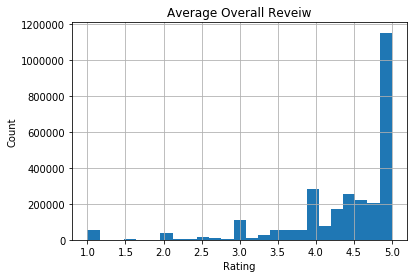

In [24]:
avg_overall['overall'].hist(bins=25)
plt.title('Average Overall Reveiw')
plt.xlabel('Rating')
plt.ylabel('Count');

This histogram shows the distribution of count of average overall review score. It is can be observed that the majority of average overall reviews are 5 and the second-highest amount is 4. In my personal experience, I only review a book when I really like it. The graph above shows that most people follow this same pattern.

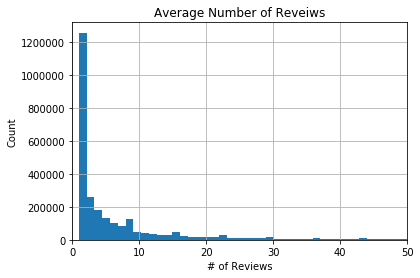

In [29]:
avg_overall['reviewCount'].hist(bins=50_000)
plt.title('Average Number of Reveiws')
plt.xlim(0, 50)
plt.xlabel('# of Reviews')
plt.ylabel('Count');

As seen in the histogram above most books have less than 10 rating forming a right skew in this data set. This is because majority of books have only 1 rating.

In [30]:
avg_overall['reviewCount'].describe()

count    2.825981e+06
mean     1.816469e+01
std      1.502179e+02
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      5.815000e+04
Name: reviewCount, dtype: float64

The mean of the number of reviews for a book is much higher than the 75% of the data set. This explains the extreme right skew that is seen as well as the significance of the number of books that have very few reviews to them.

In [33]:
avg_overall[avg_overall['reviewCount'] > 500].describe()

overall   reviewCount
count  10796.000000  10796.000000
mean       4.378202   1310.497592
std        0.332451   1971.651034
min        1.324715    501.000000
25%        4.219637    611.000000
50%        4.433264    808.000000
75%        4.609322   1277.000000
max        4.980066  58150.000000

When the minimum number of reviews for a book is set to 500 reviews the data tells a different, more accurate story. The number of books is reduced to 10,796 books which is a realistic number of books for a store to either hold the ability to order at once. The books involved in this data set are of higher quality and will give better user review data.

In [111]:
#minimum book count set to 500 for data set above
reduced_bookcount = avg_overall[avg_overall['reviewCount'] > 500]

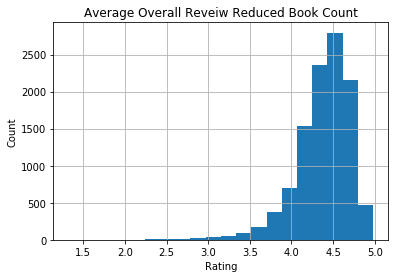

In [35]:
reduced_bookcount['overall'].hist(bins=20)
plt.title('Average Overall Reveiw Reduced Book Count')
plt.xlabel('Rating')
plt.ylabel('Count');

After removing the books that had less than 100 reviews the graph above shows a much better picture of how people rate books. Most books are rated between 4 and 5, where 5 gets fewer reviews. For the upcoming model, I will use any ratings under 4 as dislike and any above as alike. Although the ratings are out of 5 it is the mindset of the reviewer that if they found anything wrong with the book they would not give it a 4 or a 5.

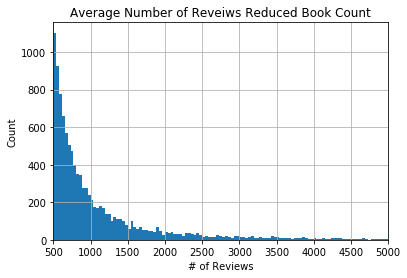

In [56]:
reduced_bookcount['reviewCount'].hist(bins=1500)
plt.title('Average Number of Reveiws Reduced Book Count')
plt.xlim(500, 5000)
plt.xlabel('# of Reviews')
plt.ylabel('Count');

The reviews show a right skew when the minimal count is set to 500. Books that have over 2500 reviews are rare and should be considered best sellers.

In [62]:
reduced_bookcount.sort_values(by = ['overall','reviewCount']).head(30)

overall  reviewCount
title                                                                    
It Could Happen To Anyone: Why Battered Women Stay  1.324715         1315
Discontinued                                        1.516364          825
Isle of Dogs (Andy Brazil)                          1.617871          526
What is Amazon Prime?: The Complete Guide to Am...  1.680247          810
Anne of Green Gables: Three Volumes in One          1.732422          512
After Dead: What Came Next in the World of Sook...  1.937380         1565
Melanie's Marvelous Measles                         1.988395          517
Bend, Not Break: A Life in Two Worlds               2.158940          906
Hazardous Duty (A Presidential Agent Novel)         2.194710         1777
Predator (Kay Scarpetta)                            2.303175          630
United States History: Preparing for the Advanc...  2.327001          737
Free Money ""They"" Don't Want You to Know About    2.363215          647
The Cat Who Had 60 Whiskers                         2.382576          528
You've Been Warned                                  2.407720          829
The Weight Loss Cure They Don't Want You to Kno...  2.423885          762
To Train Up a Child: Child Training for the 21s...  2.446691         3067
Jack Reacher's Rules                                2.511719          768
Learn How To Increase Your Chances of Winning T...  2.511905          504
Blow Fly (A Scarpetta Novel)                        2.577889          796
Out of the Dark                                     2.587891          512
Becoming Marta                                      2.653400          603
Aftermath: Star Wars: Journey to Star Wars: The...  2.687065         2729
Incubus Dreams (Anita Blake Vampire Hunter)         2.688985          926
The Golem of Hollywood                              2.696970          726
The Rule of Four. Ian Caldwell & Dustin Thomason    2.702479         1210
Shadow of Victory (Honor Harrington)                2.726027          803
Portrait of a Killer : Jack the Ripper - Case C...  2.728013          614
Son of Stone (Stone Barrington)                     2.739280          583
The Witches: Salem, 1692                            2.751894          528
The Fracking King                                   2.773214          560

The table above shows the 30 worst rated books by users. This is significant because 500 unique users rated these books very low. It can be observed that the amazon prime user manual is very lowly rated, which shows the data set is not bias towards amazon products.

In [63]:
#reduces book review data set to only include books that have over 500 reviews

reduced_book_reviews = book_reviews[book_reviews['title'].isin(reduced_bookcount.index)]

In [64]:
reduced_book_reviews.shape

(14148132, 4)

The number of reviews reduced from 51million to 14million after the minimal review was set for each book.

In [65]:
single_vc(reduced_book_reviews, column_list)

title has 0 rows with 1 data point
reviewerID has 3686081 rows with 1 data point


In [67]:
#code based off of solution found on 
#https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition

counts = reduced_book_reviews['reviewerID'].value_counts()

Removed reviews where reviewers only reviewed one book. I am trying to find correlations between books and reviewers with only one review are not valuable to the model.

In [71]:
reduced_reviewer_df = reduced_book_reviews[~reduced_book_reviews['reviewerID'].isin(counts[counts < 10].index)]

In [72]:
reduced_reviewer_df.shape

(3465689, 4)

The final data set that will be used for the model is created after removing the reviewers that have less than 10 books. When using the application, a new reviewer will be prompted to rate 10 books that they have already read. Modeling with a data set with similar reviewer trends not only gives better results but also reduces the data set to only 3.4million records.

## Model

### Pivot Table

In [73]:
pivot = reduced_reviewer_df.pivot_table(index='title', columns='reviewerID', values='overall')

In [76]:
pivot.head()

reviewerID                                          A0020356UF96ZV361ST  \
title                                                                     
#AskGaryVee: One Entrepreneur's Take on Leaders...                  NaN   
#Girlboss                                                           NaN   
#Nerd (Hashtag)                                                     NaN   
#Starstruck (A #Lovestruck Novel)                                   NaN   
'Salem's Lot                                                        NaN   

reviewerID                                          A00463782V7TKAP9EMNL  \
title                                                                      
#AskGaryVee: One Entrepreneur's Take on Leaders...                   NaN   
#Girlboss                                                            NaN   
#Nerd (Hashtag)                                                      NaN   
#Starstruck (A #Lovestruck Novel)                                    NaN   
'Salem's Lot                                                         NaN   

reviewerID                                          A0090831Q386KET36YQW  \
title                                                                      
#AskGaryVee: One Entrepreneur's Take on Leaders...                   NaN   
#Girlboss                                                            NaN   
#Nerd (Hashtag)                                                      NaN   
#Starstruck (A #Lovestruck Novel)                                    NaN   
'Salem's Lot                                                         NaN   

reviewerID                                          A0090953K7LNUG6UPMI6  \
title                                                                      
#AskGaryVee: One Entrepreneur's Take on Leaders...                   NaN   
#Girlboss                                                            NaN   
#Nerd (Hashtag)                                                      NaN   
#Starstruck (A #Lovestruck Novel)                                    NaN   
'Salem's Lot                                                         NaN   

reviewerID                                          A0092581WFYQNV4KMUZ3  \
title                                                                      
#AskGaryVee: One Entrepreneur's Take on Leaders...                   NaN   
#Girlboss                                                            NaN   
#Nerd (Hashtag)                                                      NaN   
#Starstruck (A #Lovestruck Novel)                                    NaN   
'Salem's Lot                                                         NaN   

reviewerID                                          A0099735VDZ3HDCAAYKL  \
title                                                                      
#AskGaryVee: One Entrepreneur's Take on Leaders...                   NaN   
#Girlboss                                                            NaN   
#Nerd (Hashtag)                                                      NaN   
#Starstruck (A #Lovestruck Novel)                                    NaN   
'Salem's Lot                                                         NaN   

reviewerID                                          A010388367GL2PBQC3JY  \
title                                                                      
#AskGaryVee: One Entrepreneur's Take on Leaders...                   NaN   
#Girlboss                                                            NaN   
#Nerd (Hashtag)                                                      NaN   
#Starstruck (A #Lovestruck Novel)                                    NaN   
'Salem's Lot                                                         NaN   

reviewerID                                          A0119044X1GAIYGKN8J1  \
title                                                                      
#AskGaryVee: One Entrepreneur's Take on Leaders...                   NaN   
#Girlboss                                       

In order to create a cosine similarity sparse matrix a pivot table with the reviewers as the columns, overall score as the values, and book title as the index must be created. This new data set will give the algorithm the opportunity to see how each book faired given what a reviewer rated it as. This table shows that more than 173 thousand reviewers will be used for ratings. As customers use this app a new column will be added to it with that user's ratings. The model in return will learn the trends and give more accurate results.

### Pickle

In [74]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [75]:
save_obj(reduced_reviewer_df, 'reduced_reviewer_data')

save_obj(pivot, 'pivot_data')

After the pivot table is created, the app needs to gain access to it. Repeating the steps above would take way too long and would have abad user experience. To avoid that, pickle is used to create a binary file that a server code is able to read in.

### Sparse Cosine Similarity Matrix

In [81]:
sparse_pivot = sparse.csr_matrix(pivot.fillna(0))

In [82]:
recommender = cosine_similarity(sparse_pivot)
recommender_df = pd.DataFrame(recommender, columns=pivot.index, index=pivot.index)
recommender_df.head()

title                                               #AskGaryVee: One Entrepreneur's Take on Leadership, Social Media, and Self-Awareness  \
title                                                                                                                                      
#AskGaryVee: One Entrepreneur's Take on Leaders...                                                1.0                                      
#Girlboss                                                                                         0.0                                      
#Nerd (Hashtag)                                                                                   0.0                                      
#Starstruck (A #Lovestruck Novel)                                                                 0.0                                      
'Salem's Lot                                                                                      0.0                                      

title                                               #Girlboss  \
title                                                           
#AskGaryVee: One Entrepreneur's Take on Leaders...        0.0   
#Girlboss                                                 1.0   
#Nerd (Hashtag)                                           0.0   
#Starstruck (A #Lovestruck Novel)                         0.0   
'Salem's Lot                                              0.0   

title                                               #Nerd (Hashtag)  \
title                                                                 
#AskGaryVee: One Entrepreneur's Take on Leaders...         0.000000   
#Girlboss                                                  0.000000   
#Nerd (Hashtag)                                            1.000000   
#Starstruck (A #Lovestruck Novel)                          0.044503   
'Salem's Lot                                               0.000000   

title                                               #Starstruck (A #Lovestruck Novel)  \
title                                                                                   
#AskGaryVee: One Entrepreneur's Take on Leaders...                           0.000000   
#Girlboss                                                                    0.000000   
#Nerd (Hashtag)                                                              0.044503   
#Starstruck (A #Lovestruck Novel)                                            1.000000   
'Salem's Lot                                                                 0.000000   

title                                               'Salem's Lot  \
title                                                              
#AskGaryVee: One Entrepreneur's Take on Leaders...           0.0   
#Girlboss                                                    0.0   
#Nerd (Hashtag)                                              0.0   
#Starstruck (A #Lovestruck Novel)                            0.0   
'Salem's Lot                                                 1.0   

title                                               'Scuse Me While I Kill This Guy  \
title                                                                                 
#AskGaryVee: One Entrepreneur's Take on Leaders...                         0.000000   
#Girlboss                                                                  0.000000   
#Nerd (Hashtag)                                                            0.000000   
#Starstruck (A #Lovestruck Novel)                                          0.006104   
'Salem's Lot                                                               0.000000   

title                                               (R)evolution (Phoenix Horizon)  \
title                                                                                
#AskGaryVee: One Entrepreneur's Take on Leaders...                        0.000000   
#Girlboss                                                                 0.004205   
#Nerd (Has

Using the pivot table a sparse matrix was created where each cell is the cosine similarity of the book index vs the book in the column header. Each user rating is seen as a vector that is input into this algorithm where the output is how similar the books are given the input vectors. Cosine similarity is an optimization function where the closer to 1 the score is the better it is. This model uses unsupervised learning, so the interpretation of the results is important for the model to succeed. Going forward user feedback will drive results and be the performance metric.

### Model Evaluation

In [92]:
recommender_df['The Great Gatsby (Collins Classics)'].sort_values(ascending = False)

title
The Great Gatsby (Collins Classics)                                                     1.000000
The Catcher in the Rye (Modern Classics S.)                                             0.149363
The Sun Also Rises (Scribner Classics)                                                  0.133489
Cannery Row                                                                             0.121628
Of Mice and Men                                                                         0.121206
                                                                                          ...   
NKJV Study Bible, Leathersoft, Brown: Second Edition                                    0.000000
NKJV, The Chronological Study Bible, Imitation Leather, Brown                           0.000000
NO EXIT a gripping thriller full of heart-stopping twists                               0.000000
NPCs                                                                                    0.000000
#AskGaryVee: One Entrepr

Diving deeper into the output of the cosine similarity recommendation data set it is seen that the book that is most like the input book, "The Great Gatsby (Collins Classics)", is the book itself. The top books that are most similar to it are literary classics which someone who is reading Gatsby would most likely also read. Personally I read all of these books for 10th grade English further confirming that the model created is a good one.

In [110]:
#The following print paradigm is based on code created by Riley
search = "The Kite Runner"

for title in reduced_reviewer_df.loc[reduced_reviewer_df['title'].str.contains(search), 'title']:
    print(title)
    print('Average rating', pivot.loc[title, :].mean())
    print('Number of ratings', pivot.T[title].count())
    print('')
    print('5 closest books')
    print(recommender_df[title].sort_values(ascending = False)[1:6])
    print('')
    print('*******************************************************************************************')
    print('')

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*****************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*********************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*********************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*********************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*********************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runne

Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*********************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner
Average rating 4.5514018691588785
Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************

Number of ratings 1391

5 closest books
title
The Kite Runner (Chinese Edition)                    0.999581
A Thousand Splendid Suns: A Novel                    0.272541
The Curious Incident of the Dog in the Night-Time    0.132322
Time Traveler's Wife                                 0.125786
Life of Pi                                           0.111761
Name: The Kite Runner, dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

********************************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

******************************************************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

*******************************************************************************************

The Kite Runner (Chinese Edition)
Average rating 4.551079136690648
Number of ratings 1390

5 closest books
title
The Kite Runner                                      0.999581
A Thousand Splendid Suns: A Novel                    0.272656
The Curious Incident of the Dog in the Night-Time    0.132377
Time Traveler's Wife                                 0.125839
Life of Pi                                           0.111808
Name: The Kite Runner (Chinese Edition), dtype: float64

**************

The print statements above are a sample user interface that can be used in the application itself. These results can also be used to create a json file that returns in an API call for the application.

## Conclusions and Recommendations

Machine learning models can be used to accurately recommend that a customer inputs into a search bar given previous reviews of customers. This was shown by creating a cosine similarity sparse matrix using quality reviews/reviewers discovered in the Amazon book review data set. Using this model I recommend creating a reviewer algorithm that learns as it grows. This is accomplished by adding new users to the pivot table prior to the initialization of the model. Doing this will help the algorithm be more accurate and give better recommendations going forward.  
  
This project has inspired me to do further development using the model created. Not only can I use this process to create recommendations for other products, category agnostic, but I can create a weighted algorithm that returns books based on an input genre and price range. Doing this will automate the book-buying experience and reduce human interaction in bookstores. Bookstores were struggling prior to the pandemic and not needing a return in staff may help them stay afloat.  
  
Reversing the weighted review algorithm I created returns reviewers that are more likely to buy a book based off of their reviewing history. This can be used to accurately target customers for promotional emails when a new book comes out. This not only drives sales up but makes the promotional process a lot more efficient.  
  
Going forward I intend on making this model into an API that other bookstores, fictional and not, can use to help in this new world we are living in. Having other bookstores means more customers which means more user data. Having all of the new diverse users will help the model become stronger and will also be a great stream of revenue outside of book sales. 

## References

Source of Data:  
Jianmo Ni, Jiacheng Li, Julian McAuley  
Empirical Methods in Natural Language Processing (EMNLP), 2019  
https://nijianmo.github.io/amazon/index.html.